Rock Paper Scissor

In [53]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#         print("GPU is available and configured")
#     except RuntimeError as e:
#         print(e)

In [54]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

Opretter:  
x_train: Numpy arrays of the images of the training dataset  
y_train: Labels of the training dataset  
x_test: Numpy arrays of the images of the testing dataset  
y_test: Labels of the testing dataset  
x_val: Numpy arrays of the images of the validation dataset  
y_val: Labels of the validation dataset  

In [55]:
train_path="data/train"
test_path="data/test"
val_path="data/valid"

x_train=[]
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

x_test=[]
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

x_val=[]
for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

Normalisering.  
RGB værdier ligger mellem 0 og 255. De skal bringes til at ligge mellem 0 og 1.

In [56]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

Vi bruger ImageDataGenerator til at løbe igennem mapperne, hvor billederne ligger og henter labels herfra. Labels er: rock, paper og scissors. 

In [57]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 9700 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


Nu trækker vi labels ud fra training_set.classes, test_set.classes og val_set.classe.  
De gemmes i train_y, test_y og val_y.  

In [58]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

We must also understand how the classes have been encoded to interpret classification reports and confusion matrix later. We see that y_train,y_val, and y_test are one-dimensional arrays which imply that the labels are NOT one-hot encoded.
If labels were one-hot encoded, these values would have been two-dimensional arrays.  
To do this:

In [59]:
training_set.class_indices

{'Apple': 0, 'Banana': 1, 'Grape': 2, 'Mango': 3, 'Strawberry': 4}

In [60]:
train_y.shape,test_y.shape,val_y.shape

((9700,), (100,), (200,))

Model Building

Coming to the implementation, let us first import VGG-19:

In [61]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

Now, to customize the model, we have to change its last layer alone according to the number of classes in our problem. As we have only three categories, we can code it this way:

In [62]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

Finally, our model can be summarized using:

In [63]:
# view the structure of the model
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │       125,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,149,829 (76.87 MB)

 Trainable params: 125,445 (490.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Compiling the model

In step-2, we observed that the labels of none of the datasets are one-hot encoded. So, we should use sparse categorical cross-entropy as our loss function. We will use the best optimizer called adam optimizer as it decides the best learning rate on its own.

In [64]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

Fitting the model

Hurrah! We are now good to go and train our model! However, we must ensure that our model does not get overfit during the training.
Overfitting is said to be the phenomenon due to which our model will work perfectly on our train dataset but will not work very well on new data. In that case, the model is also said to be overfitted to the particular dataset.
Thus, let us use early stopping to stop training the model any further if the validation loss suddenly starts increasing.

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

The loss must decrease gradually as the model gets trained. Let us train the model for, say,10 epochs. In case overfitting is observed anytime during the training, the above code waits for five more epochs(indicated by patience=5 in the above code).

A contiguous increase of validation loss for more than five epochs forcibly stops the model training.

In [66]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 2164s 7s/step - accuracy: 0.6039 - loss: 1.2207 - val_accuracy: 0.7600 - val_loss: 0.6612
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.8586 - loss: 0.4013 - val_accuracy: 0.8000 - val_loss: 0.6000
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - accuracy: 0.9007 - loss: 0.2804 - val_accuracy: 0.8300 - val_loss: 0.4745
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9602 - loss: 0.1408 - val_accuracy: 0.8100 - val_loss: 0.5627
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.9767 - loss: 0.1020 - val_accuracy: 0.7900 - val_loss: 0.6509
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.9890 - loss: 0.0652 - val_accuracy: 0.7850 - val_loss: 0.5819
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.9906 - loss: 0.0528 - val_accuracy: 0.8150 - val_loss: 0.5286
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.9985 - loss: 0.0347 - val_acc

The above snippet should have been clear why we obtained x_train,x_val, y_train, and y_val in step-2. It is better to set shuffle to True so that the model does not see the same image repeatedly in different batches.

Det tog 38 minutter og 25 sekuder at træne modellen. During the training, both training and validation losses decreased gradually. Although the validation loss suddenly grew a bit twice in the fourth and the eight epochs, it immediately reduced in the very next epochs. Hence, no overfitting was observed.

The performance of our model on training and validation datasets can be visualized with the help of accuracy and loss graphs as follows:

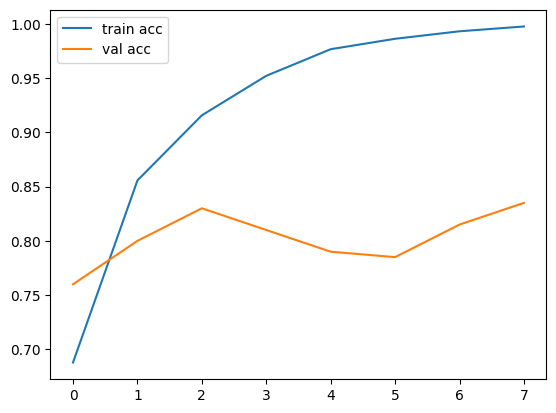

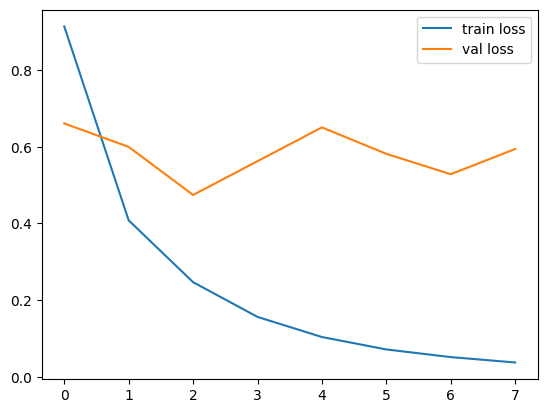

In [73]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

Model Evaluation

Now, let us evaluate our model by testing it on the test dataset.

In [74]:
model.evaluate(test_x,test_y,batch_size=32)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8285 - loss: 0.6003


[0.47958260774612427, 0.8500000238418579]

Awesome! Our model shows a testing accuracy of 100% and its testing time is 1 minut og 2 sekunder for 437 images. 

However, to call our deep learning model good and efficient, it is not only enough to look at its accuracy but it is also equally essential to observe its classification report and confusion matrix. This is another reason behind computing x_test and y_test in step-2.

In [75]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

#get classification report
print(classification_report(y_pred,test_y))

#get confusion matrix
print(confusion_matrix(y_pred,test_y))

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        14
           1       0.80      0.89      0.84        18
           2       0.95      0.76      0.84        25
           3       1.00      0.83      0.91        24
           4       0.80      0.84      0.82        19

    accuracy                           0.85       100
   macro avg       0.85      0.86      0.85       100
weighted avg       0.87      0.85      0.85       100

[[14  0  0  0  0]
 [ 1 16  0  0  1]
 [ 5  1 19  0  0]
 [ 0  1  0 20  3]
 [ 0  2  1  0 16]]


Confusion matriksen viser at alle test billederne er klassificeret korrekt.

Test på uploadede billeder

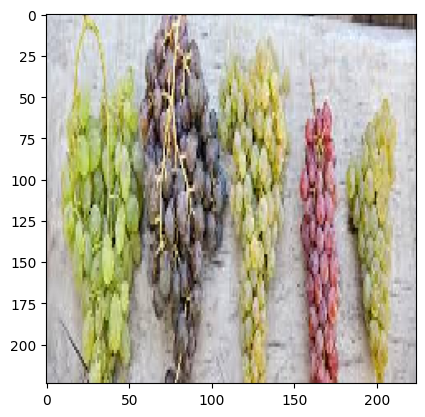

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0651934e-37 1.0000000e+00]]
Grape


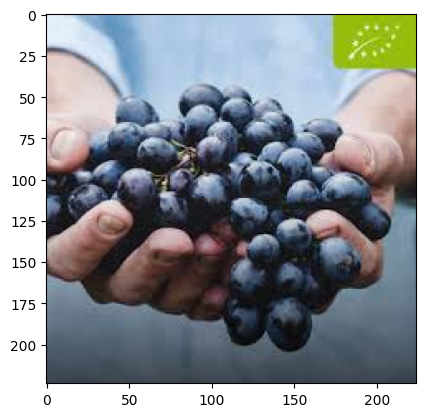

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[[0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 3.478847e-10]]
Mango


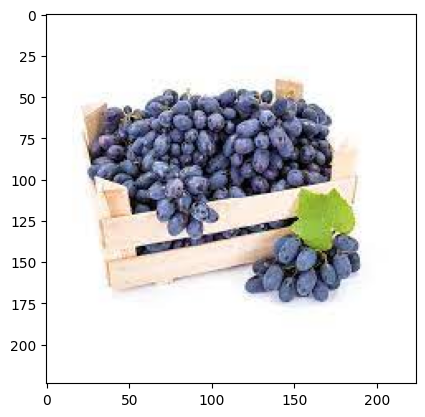

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6304727e-35]]
Apple


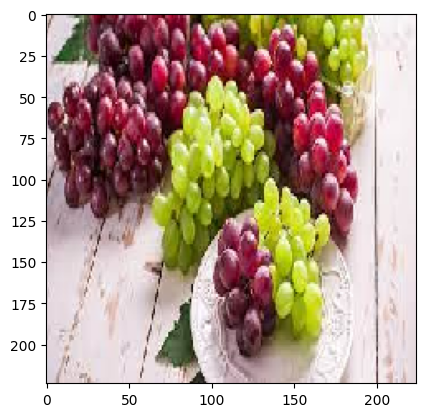

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[[0. 1. 0. 0. 0.]]
Strawberry


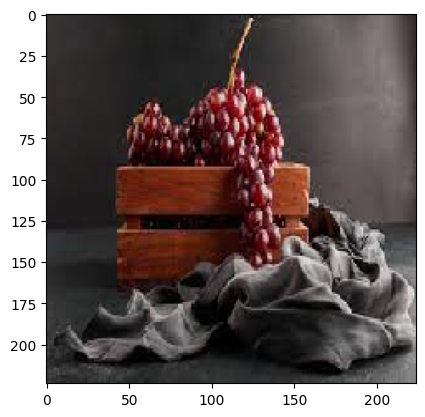

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
[[0. 0. 0. 0. 1.]]
Grape


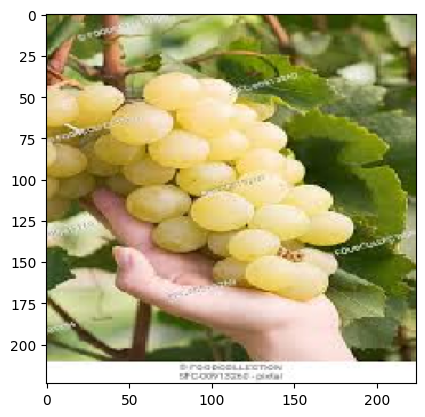

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[[0. 0. 0. 0. 1.]]
Grape


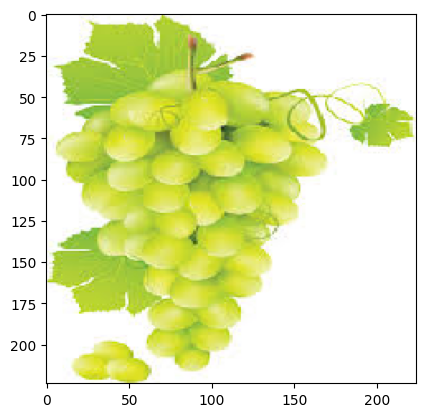

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
[[0.0000000e+00 0.0000000e+00 3.6588257e-37 0.0000000e+00 1.0000000e+00]]
Grape


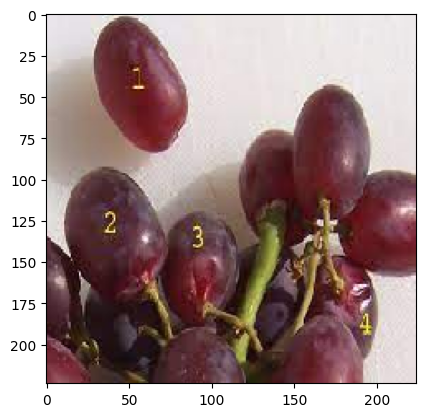

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[[8.863399e-23 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00]]
Grape


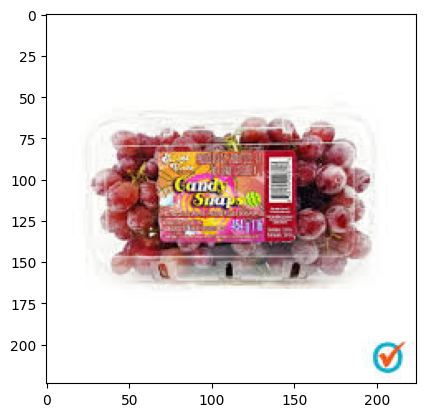

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
[[0. 0. 0. 0. 1.]]
Grape


In [81]:
path="upload"
for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    print(pred)
    if pred[0][0]>0.5:
        print("Apple")
    elif pred[0][1]>0.5:
        print("Strawberry")
    elif pred[0][2]>0.5:
        print("Mango")
    elif pred[0][3]>0.5:
        print('Banana')
    elif pred[0][4]>0.5:
        print('Grape')
    else:
        print("Unknown")



Gemmer modellen i *.h5 format så den kan loades med Tensorflow  
Gemmer modellen så den kan konverteres til tflite format og flyttes til Raspberry Pi

In [71]:

model.save("saved_model/vgg-fruit-final.keras")


In [72]:
import tensorflow as tf
saved_model_dir = "./saved_model/"

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('saved_model/model.tflite', 'wb') as f:
  f.write(tflite_model)

AttributeError: '_UserObject' object has no attribute 'add_slot'